In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import datetime

In [240]:
%matplotlib inline

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16,8)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16,8)

In [241]:
## Calculating distance (km) between two cordinates
def distance(lat1, long1, lat2, long2):
    #Radius in km
    R = 6371

    lat1=np.deg2rad(lat1)
    lat2=np.deg2rad(lat2)
    long1=np.deg2rad(long1)
    long2=np.deg2rad(long2)
    dlong = long2 - long1
    dlat = lat2 - lat1

    a = np.power((np.sin(dlat/2)), 2) + np.cos(lat1) * np.cos(lat2) * np.power(np.sin(dlong/2), 2)
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) )
    d = R * c #(where R is the radius of the Earth)
    return d

-------------------------------------------------------

# Data preparation and description

Let's start by simply importing the datasets and doing some initial restructuring

In [242]:
# importing data
df_rentals = pd.read_csv("DR_Data/Rentals_2019-4-2_1456.csv", parse_dates=[0,1])
df_hubav = pd.read_csv("DR_Data/Hubavailabilityaudits_2019-4-2_1535.csv", parse_dates=[3])
df_hubs = pd.read_csv("DR_Data/Hubs_2019-4-2_1201.csv", parse_dates=[0,-1])
df_searchlog1 = pd.read_csv("DR_Data/Searchlogs_2019-4-2_1234.csv", parse_dates=[-1])
df_searchlog2 = pd.read_csv("DR_Data/Searchlogs_2019-4-2_1504.csv", parse_dates=[-1])
df_weather = pd.read_csv("DR_Data/Daily_Weather.csv", parse_dates=[-1])

In [243]:
#concatenating searchlogs dataframes (the second file is a continuation of the first)
df_searchlog = pd.concat([df_searchlog1, df_searchlog2])
df_rentals= df_rentals.dropna()

----------------------------------

## Hubs

In what follows we aim at visualizing on the map of Copenhagen all the existing (and deleted) hubs in our dataset. In order to do this we first need to differentiate between the still existing-hubs and the deleted ones:

In [244]:
# Centered location (latitude, longitude) which we will use in all our following plots
initial_location = [55.6775757, 12.579571639999999]

In [245]:
df_deleted_hubs = df_hubs.where(pd.notna(df_hubs.deleted_at) == True).dropna()

In [246]:
df_existing_hubs = df_hubs.where(pd.notna(df_hubs.deleted_at) == False).dropna(how='all')
# df_existing_hubs = df_existing_hubs[(df_existing_hubs.latitude<=55.725) & (55.625<=df_existing_hubs.latitude) & (12.5<=df_existing_hubs.longitude) & (12.65>df_existing_hubs.longitude)]

df_existing_hubs = df_existing_hubs[(df_existing_hubs.latitude<=55.72) & (55.65<=df_existing_hubs.latitude) & (12.50<=df_existing_hubs.longitude) & (12.66>df_existing_hubs.longitude)]

In [247]:
df_existing_hubs.head(10)

,created_at,latitude,longitude,id,name,deleted_at
1,2018-11-26 09:06:05.590590,55.695252,12.547185,6367.0,Heinesgade,NaT
3,2018-05-28 20:07:34.173984,55.668700,12.551114,3526.0,Saxogade,NaT
4,2018-11-08 09:36:50.440822,55.699557,12.515065,6233.0,GrÃ¸ndal Multicenter,NaT
5,2018-01-16 19:05:49.192033,55.682669,12.577611,2350.0,Egmont,NaT
6,2018-01-09 14:53:52.744834,55.668653,12.543646,2276.0,Vega,NaT
7,2019-03-14 11:39:00.814359,55.697218,12.584605,7148.0,SÃ¸nderborggade,NaT
8,2018-07-22 15:03:16.438551,55.669671,12.545824,4947.0,MatthÃ¦usgade,NaT
9,2019-03-20 13:50:30.943318,55.678997,12.586016,7316.0,Kongens Nytorv,NaT
10,2018-01-12 10:51:37.354963,55.656739,12.588744,2288.0,DR Byen,NaT
12,2018-02-19 16:37:48.343912,55.653187,12.610643,2453.0,Peder Lykkes Vej,NaT


Ok, so now we are ready to plot the hubs on the map differentiating the existing (in blue) from the deleted (in red) 

In [248]:
# Getting latitude-longitude locations for all the hubs
existing_locations = df_existing_hubs.iloc[:, 1:3].values.tolist()
del_hub_locations = df_deleted_hubs.iloc[:, 1:3].values.tolist()

In [259]:
# manually selected areas:
#          noerreport
#          cph H
#          kongens nytorv
#          christiansborg
#          marmorkirken (metro)
circle_center = np.array([[55.683087, 55.679440, 55.676435, 55.685250, 55.678997],
                  [12.571737, 12.585218, 12.579440, 12.588051, 12.568799]])
radius = 200 # meters

KeyError: ('longitude', 'latitude')

In [250]:
hub_map = folium.Map(location=initial_location, zoom_start=13)

for point in range(0, len(existing_locations)):
    folium.CircleMarker(
    location=existing_locations[point],
    radius=3,
    popup='Hub_{}'.format(df_existing_hubs.iloc[point, 3]),
    color='#363636',
    fill=True,
    fill_color='#363636').add_to(hub_map)
for i in range(0,circle_center.shape[1]):
   folium.Circle(
      location=[circle_center[0,i], circle_center[1,i]],
      radius=radius,
      color='crimson',
      fill=False).add_to(hub_map)
hub_map

In [251]:
# adding zone id information
def helper_zone(df):
    for j in range(circle_center.shape[1]):
        dist_from_center = distance(df['latitude'], df['longitude'],
                                    circle_center[0][j], circle_center[1][j])
        if(dist_from_center<=radius/1000):
            #print(df['id'], j)
            zone = int(j)
            break
        zone = np.nan
    return zone
zone = df_existing_hubs.apply(helper_zone, axis=1)
df_existing_hubs = df_existing_hubs.assign(zone=zone)

In [252]:
from collections import OrderedDict
from collections import defaultdict

hub2zone = OrderedDict(zip(df_existing_hubs.id, df_existing_hubs.zone))
# temp = defaultdict(zip(df_existing_hubs.id, df_existing_hubs.zone))
hub2zone[2262]

nan

In [253]:
def helper(hub_id):
    try:
        return int(hub2zone[hub_id])
    except:
        return np.nan
    
pickup_zone = df_rentals.pickup_hub_id.apply(helper)
dropoff_zone = df_rentals.dropoff_hub_id.apply(helper)
df_rentals = df_rentals.assign(pickup_zone=pickup_zone, dropoff_zone=dropoff_zone)
df_rentals = df_rentals.dropna()
df_rentals.pickup_zone = df_rentals.pickup_zone.astype(int)
df_rentals.dropoff_zone = df_rentals.dropoff_zone.astype(int)

df_rentals.head(10)

,created_at,finished_at,pickup_hub_id,dropoff_hub_id,user_id,pickup_zone,dropoff_zone
10,2018-03-03 10:24:13.140452,2018-03-04 12:37:03.620000,2154,2154.0,113976,1,1
11,2018-03-03 10:24:03.087379,2018-03-04 12:44:22.061000,2344,2344.0,113973,1,1
36,2018-03-06 16:18:53.351902,2018-03-06 17:51:25.073000,2154,2154.0,114352,1,1
52,2018-03-08 18:20:33.563739,2018-03-08 22:14:02.872000,2344,2344.0,30375,1,1
188,2018-03-15 10:41:23.549453,2018-03-15 18:08:00.660835,2161,2161.0,37494,0,0
203,2018-03-16 08:14:42.731878,2018-03-16 20:13:28.164000,2529,2529.0,115928,1,1
260,2018-03-19 10:08:33.491082,2018-03-19 13:10:34.455000,1514,1514.0,116443,0,0
359,2018-03-21 19:57:31.781012,2018-03-24 15:03:25.536000,2529,2529.0,116708,1,1
360,2018-03-24 13:23:11.165971,2018-03-24 15:21:25.941107,2529,1750.0,117217,1,4
395,2018-03-25 08:50:57.054926,2018-03-25 14:41:49.119830,2346,2346.0,117344,1,1


0.8516900436882042


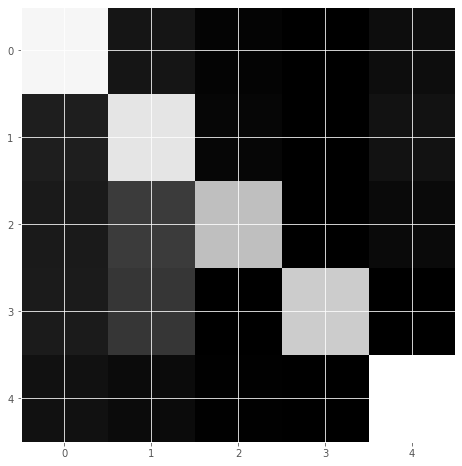

In [254]:
from prob_mat import probability_matrix
from prob_mat import count_matrix

prob_mat = probability_matrix(df_rentals)
count_mat = count_matrix(df_rentals)

print(np.sum(np.diag(count_mat))/np.sum(count_mat))

plt.imshow(prob_mat, 'gray')
plt.show()

In [255]:
df_existing_hubs.id.nunique()

979

In [256]:
def cycle_encoder(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [257]:
def helper2(time):
        #date_string=time[0:10]
        #date=datetime.date(*map(int,(date_string.split("-"))))
        return time.weekday()
    
def helper3(time):
    return time.month

def helper4(time):
    return str(time.date())

def helper5(time):
    return  time.hour

    

weekday=df_rentals.created_at.apply(helper2)
month=df_rentals.created_at.apply(helper3)
Day=df_rentals.created_at.apply(helper4)
hour=df_rentals.created_at.apply(helper5)

df_rentals = df_rentals.assign(weekday=weekday)
df_rentals = df_rentals.assign(month=month)
df_rentals = df_rentals.assign(Day=Day)
df_rentals = df_rentals.assign(hour=hour)

df_rentals = cycle_encoder(df_rentals, 'weekday', 7)
df_rentals = cycle_encoder(df_rentals, 'month', 12)
df_rentals = cycle_encoder(df_rentals, 'hour', 24)

def latitude(zone):
    return centroids_list[zone][1]

def longitude(zone):
    return centroids_list[zone][0]

Centroids_lat_pickup = df_rentals.pickup_zone.apply(latitude)
Centroids_long_pickup = df_rentals.pickup_zone.apply(longitude)
Centroids_lat_dropoff = df_rentals.dropoff_zone.apply(latitude)
Centroids_long_dropoff = df_rentals.dropoff_zone.apply(longitude)
df_rentals = df_rentals.assign(Centroids_lat_pickup=Centroids_lat_pickup)
df_rentals = df_rentals.assign(Centroids_long_pickup=Centroids_long_pickup)
df_rentals = df_rentals.assign(Centroids_lat_dropoff=Centroids_lat_dropoff)
df_rentals = df_rentals.assign(Centroids_long_dropoff=Centroids_long_dropoff)

df_rentals=df_rentals.merge(df_weather[['Day','air_temperature','rain_duration','rain_intensity','GHI']],how='left',on='Day')



NameError: name 'centroids_list' is not defined

In [ ]:
import math
print(df_rentals.shape)
df_rentals=df_rentals.dropna()
df_rentals.head(40)

In [ ]:
#df_rentals.to_pickle('DR_Data/rentals.pickle')
print(max(df_rentals.hour))
print('saved')

In [ ]:
from math import sin, cos, sqrt, atan2
def distance(z1,z2):
    R = 6373.0
    lat1=z1[0]
    lon1=z1[1]
    lat2=z2[0]
    lon2=z2[1]
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return (R * c)**2

Euc_distances_sq=np.zeros((len(centroids_list),len(centroids_list)))

for i in range(len(centroids_list)):
    for j in range(len(centroids_list)):
        Euc_distances_sq[i][j]=distance(centroids_list[i],centroids_list[j])

#np.save('DR_Data/Zone_distances',Euc_distances_sq,allow_pickle=True)

print(Euc_distances)
print(np.exp(Euc_distances))